<a href="https://colab.research.google.com/github/rcnewman/cv_gesture_recognition_posenet/blob/master/PoseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PoseNet-python Notebook Source: https://colab.research.google.com/drive/1Ha7-lt-WwcCx961cuatjOzQ-7GLY91aQ#scrollTo=k_qlzhSXN3D7
# install
!git clone https://github.com/rcnewman/posenet-python.git #fork from https://www.github.com/rwightman/posenet-python 
%cd posenet-python
!pip3 install tensorflow-gpu==1.15
!pip3 install scipy
!pip3 install pyyaml
!pip3 install opencv-python
!pip3 install ipykernel
!pip3 install msgpack-numpy
!pip3 install ffmpeg-python

Cloning into 'posenet-python'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 143 (delta 11), reused 17 (delta 7), pack-reused 120
Receiving objects: 100% (143/143), 42.86 KiB | 8.57 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/posenet-python
     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 3.8MB 55.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 512kB 44.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=0d49ec8ea62cd1c9dee691259d6f2ed83972c4c8720051b3574e264615e461f8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requireme

In [14]:
#CONFIG
max_pose_detections = 1
min_pose_score = 0.25
min_part_score = 0.25
SAVE_KEYPOINTS = True
DEBUG = False
SAVE_VIDEO = True

In [3]:
import ffmpeg    
# Fix rotation, code from https://stackoverflow.com/questions/53097092/frame-from-video-is-upside-down-after-extracting
def check_rotation(path_video_file):
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)

    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotateCode = None
    if 'rotate' in meta_dict['streams'][0]['tags']:
      if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
          rotateCode = cv2.ROTATE_90_CLOCKWISE
      elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
          rotateCode = cv2.ROTATE_180
      elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
          rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE

    return rotateCode

def correct_rotation(frame, rotateCode):  
    return cv2.rotate(frame, rotateCode) 

In [19]:
# PoseNet python sample program initialization
import tensorflow as tf
import cv2
import time
import argparse
import os
import posenet
import glob
import msgpack
import msgpack_numpy as m
m.patch() #for handling numpy arrays w/ msgpack
print('INIT:')
from google.colab import drive
drive.mount('/content/drive')
drivepath="/content/drive/My Drive/POSENET/"
# driveinfile = drivepath + 'input.mp4'
video_path = glob.glob(drivepath + 'vids/*.mp4')
save_video_path = drivepath + 'output_vids/'
keypts_path = drivepath +'keypts/'
labels_path = drivepath +'gesture_labels/'
# VideoReaderWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

font = cv2.FONT_HERSHEY_SIMPLEX 
org = (5, 30) 
fontScale = 1
color = (0, 255, 0) 
thickness = 2
   
model = 101
###scale_factor = 1.0
scale_factor = 0.4

INIT:
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# PoseNet python sample program run

with tf.Session() as sess:
    print('MODEL-INIT:')
    ####model_cfg, model_outputs = posenet.load_model(args.model, sess)
    model_cfg, model_outputs = posenet.load_model(model, sess)
    output_stride = model_cfg['output_stride']
    start = time.time()
    print('START:')
    for vid in video_path:
      cap = cv2.VideoCapture(vid)

      rotateCode = check_rotation(vid)

      incnt = 0
      keypoints_save = []
      if SAVE_VIDEO:
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        driveoutfile = save_video_path + os.path.basename(vid)
        video = cv2.VideoWriter(driveoutfile, fourcc, fps, (width, height))
      while True:
          incnt = incnt + 1
          try: input_image, draw_image, output_scale = posenet.read_cap(
                  cap, scale_factor=scale_factor, output_stride=output_stride,rotate_code=rotateCode)
          except:break
          heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
              model_outputs,
              feed_dict={'image:0': input_image}
          )
          pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
              heatmaps_result.squeeze(axis=0),
              offsets_result.squeeze(axis=0),
              displacement_fwd_result.squeeze(axis=0),
              displacement_bwd_result.squeeze(axis=0),
              output_stride=output_stride,
              max_pose_detections=max_pose_detections,
              min_pose_score=min_pose_score)

          keypoint_coords *= output_scale

          if SAVE_KEYPOINTS:
            keypoints_save.append(keypoint_coords)
          
          if SAVE_VIDEO:
            draw_image = posenet.draw_skel_and_kp(
                    draw_image, pose_scores, keypoint_scores, keypoint_coords,
                    min_pose_score=min_pose_score, min_part_score=min_part_score)
            draw_image = cv2.putText(draw_image, str(incnt), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
            video.write(draw_image)
          if incnt % 100 == 0:        
              print("cnt=", incnt, "fps=", incnt / (time.time() - start) )

          if DEBUG:
              #debug
              for pi in range(len(pose_scores)):
                  if pose_scores[pi] == 0.:
                      break
                  print('Pose #%d, score = %f' % (pi, pose_scores[pi]))
                  for ki, (s, c) in enumerate(zip(keypoint_scores[pi, :], keypoint_coords[pi, :, :])):
                      print('Keypoint %s, score = %f, coord = %s' % (posenet.PART_NAMES[ki], s, c))
      
      cap.release()

      if SAVE_KEYPOINTS:
        with open(keypts_path + os.path.basename(vid)[0:-4] + "_pts.msgpack", 'wb') as f:
          packed = msgpack.packb(keypoints_save)
          f.write(packed)

      if SAVE_VIDEO:
         print(os.path.basename(vid)[0:-4])
         video.release()

print('END:')


MODEL-INIT:
START:
cnt= 100 fps= 33.64268348732395
cnt= 200 fps= 36.81344855616648
input
Copy of VID_20200909_222404
Copy of VID_20200909_223009
Copy of VID_20200909_222531 (2)
Copy of VID_20200909_222722
Copy of VID_20200909_223040
Copy of VID_20200909_222603
Copy of VID_20200909_222433
Copy of VID_20200909_222221
Copy of VID_20200909_222658
Copy of VID_20200909_222151
END:


In [6]:
import pandas as pd
import pickle
labels_path = drivepath +'gesture_labels/'
for vid in video_path:
    cap = cv2.VideoCapture(vid)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    labels=[0]*length
    try:
        df=pd.read_csv(labels_path + os.path.basename(vid)[0:-4] + ".csv",names=["start","end","label"])
        for i,row in df.iterrows():
            labels[row.start:row.end]=[row.label]*(row.end-row.start)
        print(labels)
    except:
        print(os.path.basename(vid)+"is missing the label file")
    with open(labels_path + os.path.basename(vid)[0:-4] + ".pickle","wb") as f:
        pickle.dump(labels,f)


[0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Copy of VID_20200909_222404.mp4is missing the label file
Copy of VID_20200909_223009.mp4is missing the label file
Copy of VID_20200909_222531 (2).mp4is missing the label file
Copy of 

In [7]:
# Classes ---------------------------------------------------------------------
class KerasBatchGenerator(object):

    def __init__(self, file_list, batch_size,steps,jump=1):
        self.file_list = file_list
        self.batch_size = batch_size
        self.steps=steps
        self.current_idx = 0
        self.current_file=0
        self.data=None
        self.label=None
        self.limit=0
        self.gestures=11
        self.jump=jump
        self.keypoint_number=17*2
    def generate(self):
        # Load June 1st data.
        with open(keypts_path + self.file_list[self.current_file] + "_pts.msgpack", "rb") as data_file:
            byte_data = data_file.read()
        self.data = msgpack.unpackb(byte_data)
        self.limit = len(self.data)
        with open(labels_path + self.file_list[self.current_file] + ".pickle", "rb") as label_file:
            self.label=pickle.load(label_file)
        while True:
            
            # Build empty matricies.
            #y = np.zeros((self.batch_size, self.steps))
            y = np.zeros((self.batch_size,self.steps, self.gestures))
            keypoints = np.zeros((self.batch_size, self.steps, self.keypoint_number))

            # Iterate through all files.
            for i in range(self.batch_size):
                if self.current_idx + self.steps + 1 >= self.limit:
                    self.current_file += 1
                    if(self.current_file >= len(self.file_list)):
                        self.current_file =0
                    with open(keypts_path + self.file_list[self.current_file] + "_pts.msgpack", "rb") as data_file:
                        byte_data = data_file.read()
                    self.data = msgpack.unpackb(byte_data)
                    self.limit = len(self.data)
                    self.current_idx = 0
                    with open(labels_path + self.file_list[self.current_file] + ".pickle", "rb") as label_file:
                        self.label=pickle.load(label_file)
                for k in range(self.steps):
                    keypoints[i][k][:] = self.data[self.current_idx+k][0].flatten()
                    y[i][k][:] = tf.keras.utils.to_categorical(self.label[self.current_idx+k],num_classes=self.gestures)
                #### we need to decide on a syntax for the gesture time stamps and use it in label generation
                self.current_idx += self.jump
            x = keypoints
            yield x, y
            


In [11]:
from tensorflow import keras
import os
import numpy as np
# Global Variables ------------------------------------------------------------
batch_size = 64
steps = 24
jump=8
keypoint_number=17*2
lstm_cels=keypoint_number
gesture_number=11
num_epochs=1
training_keypoints=["input" ]
valid_keypoints=["input" ]

train_data_generator = KerasBatchGenerator(training_keypoints, batch_size, steps,jump)
valid_data_generator = KerasBatchGenerator(valid_keypoints, batch_size, steps,jump)

# Set Up GPU ------------------------------------------------------------------
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"] = "0";

# Build Models ----------------------------------------------------------------
save_location='/content/drive/My Drive/POSENET/Experiments/ALL_LSTM_01'
saveFiles = ([name for name in os.listdir(save_location)])
initial_epoch = len(saveFiles)
if(len(saveFiles) > 0):
    if(len(saveFiles) > 9):
        model = tf.keras.models.load_model(save_location+"/model-"+str(len(saveFiles))+".hdf5")
    else:
        model = tf.keras.models.load_model(save_location+"/model-0"+str(len(saveFiles))+".hdf5")
    print(model.summary(90))
else:
    print("else")
    
    # Build input shapes.
    keypointInput = keras.layers.Input(shape=(steps, keypoint_number))

    
    # Build lstm layers.
    masking_layer = keras.layers.Masking(mask_value=0)(keypointInput)
    keypoint = keras.layers.LSTM(lstm_cels, return_sequences=True)(masking_layer)
    # Build dense layer
    dense_layer = keras.layers.Dense(gesture_number, activation='sigmoid')
    dense_layer2 = keras.layers.Dense(gesture_number, activation='softmax')
    gesture = keras.layers.TimeDistributed(dense_layer)(keypoint)
    softmax = keras.layers.TimeDistributed(dense_layer2)(gesture)
    
    
    model = keras.Model(inputs=keypointInput, outputs=softmax)
    print(model.summary(90))
    
# Weight and train model.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy','categorical_crossentropy'])
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=save_location+'/concat-{epoch:02d}.hdf5', verbose=1)
model.fit_generator(train_data_generator.generate(), 100, num_epochs,
                    validation_data=valid_data_generator.generate(),validation_steps=10,
                    callbacks=[checkpointer] ,
                    shuffle=False,initial_epoch=initial_epoch)

else
Model: "model_1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
input_2 (InputLayer)                    [(None, 24, 34)]                    0             
__________________________________________________________________________________________
masking_1 (Masking)                     (None, 24, 34)                      0             
__________________________________________________________________________________________
lstm_1 (LSTM)                           (None, 24, 34)                      9384          
__________________________________________________________________________________________
time_distributed_1 (TimeDistributed)    (None, 24, 11)                      385           
__________________________________________________________________________________________
time_distributed_2 (TimeDistributed)    (None, 24, 11)              

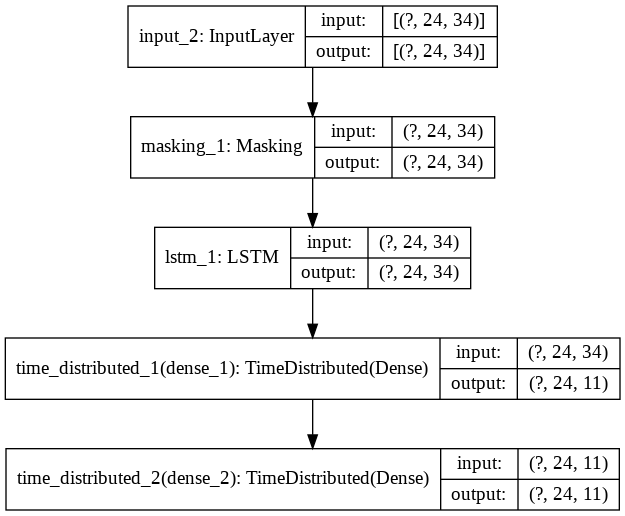

In [13]:
tf.keras.utils.plot_model(model,show_shapes=True,expand_nested=True,)